# Rank-1 Introduction

# Import packages

In [1]:
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import math
import random
from tqdm import trange, tqdm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed
clear_output()
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [2]:
p = 1
q = 2
w = 100

# Generate the Dataset

### Set parameters

In [3]:
n1 = 10
n2 = 20
N = n1*n2
states = np.arange(n1, dtype=float)
nuisances = np.arange(n2, dtype=float)

### Generate X

In [4]:
X = np.empty((N,2))
for i in range(N):
    #s = np.random.choice(states)
    #l = np.random.choice(nuisances)
    s = i//n2
    l = i%n2
    s = states[s]
    l = nuisances[l]
    X[i,0] = s    
    X[i,1] = l

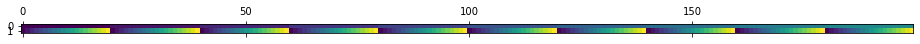

In [5]:
plt.matshow(X.T)

# Set SymAE

### Set CENc, NEnc, Dec

In [6]:
class CEnc(tf.keras.Model):
    def __init__(self, p, w):
        super(CEnc, self).__init__(name='sym_encoder')
    def call(self, x):
        return x[:,0:1]
    
# 你是在让 nuisance encoder 记住states
class NEnc(tf.keras.Model):
    def __init__(self, q, w):
        super(NEnc, self).__init__(name='nui_encoder')
        self.d1=tfkl.Dense(1, use_bias=False,
                           kernel_initializer='zeros')
        self.r1 = tf.keras.layers.RepeatVector(2)
        self.f1 = tf.keras.layers.Flatten()
    def call(self, x):
        x=self.d1(x)
        #x=tf.reduce_sum(x, axis=-1, keepdims=True)
        x=self.r1(x)
        x=self.f1(x)
        return x
    
class Dec(tf.keras.Model):
    def __init__(self, w):
        super(Dec, self).__init__(name='dec')
        self.d1=tfkl.Dense(w, activation='relu', use_bias=False)#tf.keras.layers.LeakyReLU())
        self.d2=tfkl.Dense(1, use_bias=False)
    def call(self, x):
        x=self.d1(x)
        #x=self.d2(x)
        x=tf.reduce_sum(x, axis=-1, keepdims=True)/10
        return x

### Dropout

In [7]:
class LatentCat(tf.keras.Model):
    def __init__(self):
        super(LatentCat, self).__init__(name='latentcat')
    def call(self, zsym, znui, mask=[1,1]):
        znui = znui*mask
        z = tfkl.concatenate([zsym, znui])
        return z

### model

In [8]:
class SymAE(tf.keras.Model):
    def __init__(self, p, q, w): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = CEnc(p, w)
        self.sym_encoder=sym_encoder
        
        # Build nuisance encoder
        nui_encoder = NEnc(q, w)
        self.nui_encoder = nui_encoder
        
        #Build latentcat
        latentcat = LatentCat()
        self.latentcat = latentcat  
        
        #Build dec in decoder
        dec = Dec(w)
        self.dec = dec
        
        # Build encoder
        encoder_input = tfk.Input(shape=(2), dtype='float32', name='encoder_input')
        znui = nui_encoder(encoder_input); zsym = sym_encoder(encoder_input)
        encoder_output = latentcat(zsym, znui)
        encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder=encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(1+q), name='latentcode')
        decoder_output = dec(decoder_input)
        decoder=tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder=decoder
        
    def call(self, x, mask=[1,1]):
        zsym = self.sym_encoder(x)
        znui = self.nui_encoder(x)
        z = self.latentcat(zsym, znui, mask)
        x_hat = self.dec(z)
        return x_hat
    
    def redatum(self, X1, X2):
        return model.decoder(
            model.latentcat(
                model.sym_encoder(X1), 
                model.nui_encoder(X2)))

### Initialize SymAE

In [9]:
model = SymAE(p,q,w)
# Please directly modify My_Dropout to change dropout rate
path = './p=%d,q=%d,w=%d,rate'%(p,q,w)
clear_output()

In [10]:
try:
    #model.load_weights(path+'/checkpoint')
    print("weight exists")
except:
    print("weight doesn't exist")

weight exists



### Select optimizer

In [11]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clear_output()

# Train

### Define loss

In [12]:
X1 = np.empty((N,2))
X2 = np.empty((N,2))
for i in range(N):
    X1[i,0] = np.random.choice(states)    
    X1[i,1] = np.random.choice(nuisances)
    X2[i,0] = np.random.choice(states)    
    X2[i,1] = np.random.choice(nuisances)
def redatum_loss():
    redata = model.redatum(X1,X2)
    origin = np.empty((N,2))
    origin[:,0] = X1[:,0]
    origin[:,1] = X2[:,1]
    return mse(redata, origin[:,1:2])

def loss_rec(model, x):
    x_hat_1 = model(x, mask=[1,1])
    x_hat_2 = model(x, mask=[0,1])
    x_hat_3 = model(x, mask=[1,0])
    y = x[:,1]
    return mse(y, x_hat_1) + mse(y, x_hat_2) + mse(y, x_hat_3)

### Train

In [13]:
my_list = []
for i in np.arange(0,1,0.05):
    my_list.append(i)
storage = []

In [33]:
my_list = [1.0]
storage = []

In [34]:
for r in my_list:
    model = SymAE(p,q,w)
    model.nui_encoder.d1.trainable = True    
    def loss_rec(model, x):
        x_hat_1 = model(x, mask=[1,1])
        x_hat_2 = model(x, mask=[0,1])
        x_hat_3 = model(x, mask=[1,0])
        y = x[:,1]
        return (1-r)*mse(y, x_hat_1) + r*(mse(y, x_hat_2) + mse(y, x_hat_3))
    @tf.function
    def train_step(model, X):
        with tf.GradientTape() as tape:
            loss = loss_rec(model, X)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss
    W = np.array([[0.0],[0.0]])
    model.nui_encoder.d1.set_weights([W])
    loss=0.0
    for epoch in range(10000):
        print(epoch)
        clear_output(wait=True)
        loss_rec = train_step(model, X)
        loss=loss_rec.numpy()
        clear_output(wait=True)
    W = model.get_weights()[0]
    np.save(path+'/r=%.2f'%(r), W)
    np.save(path+'/r=%.2f,l=%.6f'%(r,loss), W)
    storage.append([r,loss])
    print(model.nui_encoder.d1.get_weights())

[array([[-0.00323349],
       [ 0.31132016]], dtype=float32)]


# Contour

In [ ]:
def loss_rec1(model, x):
    x_hat_1 = model(x, mask=[1,1])
    x_hat_2 = model(x, mask=[0,1])
    x_hat_3 = model(x, mask=[1,0])
    y = x[:,1:2]
    return mse(y, x_hat_1) + mse(y, x_hat_2) + mse(y, x_hat_3)

In [ ]:
a1, b1 = 0.8, 0.4
a2, b2 = 0.0, 0.1
path1 = './p=%d,q=%d,w=%d/a=%.1f,b=%.1f'%(p,q,w,a1,b1)
path2 = './p=%d,q=%d,w=%d/a=%.1f,b=%.1f'%(p,q,w,a2,b2)
W1 = np.load(path1+'/W.npy')
W2 = np.load(path2+'/W.npy')
V1 = np.load(path1+'/V.npy')
V2 = np.load(path2+'/V.npy')
# (0,0) is a1,b1 ; (1,1) is a2,b2
Xs = np.arange(-1,2,0.1)
Ys = np.arange(-1,2,0.1)
Zs = np.empty((len(Xs),len(Ys)))
for i in trange(len(Xs)):
    for j in range(len(Ys)):
        W = Xs[i]*W2 + (1-Xs[i])*W1
        V = Ys[j]*V2 + (1-Ys[j])*V1
        model.set_weights([W, V])
        Zs[i,j] = loss_rec1(model, X)

In [ ]:
levels = np.linspace(0, 200, 100)
#levels = np.linspace(0, 1, 10)
plt.contourf(Xs, Ys, Zs.T, levels=levels)
plt.scatter([0,1],[0,1],linewidth=5, marker ='.', color='C3')
plt.xlabel('W')
plt.ylabel('V')
plt.colorbar()

# PCA

### 5-dim gas

In [ ]:
T = np.empty((w,3))
T[:,0:3] = model.dec.d1.weights[0].numpy().T
df = pd.DataFrame(T, columns=['b','c','d'])
W = model.nui_encoder.weights[0].numpy().T

In [ ]:
df = df.sort_values(by=['b'])
df = df.reset_index(drop=True)

In [ ]:
px.scatter(df)

In [ ]:
t1 = go.Scatter(x=df['c'], y=df['d'], mode='markers')
# t2 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w2'], mode='markers')
# t3 = go.Scatter3d(x=df['a'], y=df['w1'], z=df['w3'], mode='markers')
fig = go.Figure(data=[t1])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.update_traces(marker={'size': 2, 'opacity':0.8})
#fig

In [ ]:
W = model.nui_encoder.weights[0].numpy().T

In [ ]:
W

In [27]:
a=np.empty(20)
b=np.empty(20)

In [30]:
for i in range(20):
    r=my_list[i]
    a[i]=np.load(path+'/r=%.2f.npy'%(r))[0]    
    b[i]=np.load(path+'/r=%.2f.npy'%(r))[1]

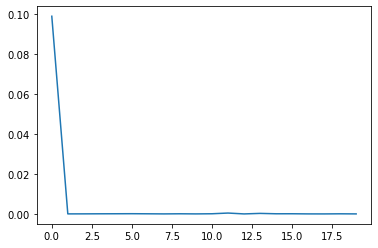

In [31]:
plt.plot(range(20))

In [32]:
a

array([ 9.87557024e-02, -2.27885412e-05, -9.43870145e-06,  2.25244621e-05,
        4.27848136e-05,  6.72953247e-05,  2.31670365e-05, -2.79052492e-05,
        2.81981338e-05, -2.81454304e-05,  4.01686702e-05,  3.92732560e-04,
       -3.91541689e-05,  2.19864291e-04,  3.13434139e-05,  4.16794792e-05,
       -2.91797514e-05, -3.81962163e-05,  1.62285414e-05, -3.10550349e-05])